In [118]:
import pylab as py

# Data handling and processing modules
import pandas as pd # table (data frame)
import numpy as np # array

# Machine Learning modules
from sklearn.model_selection import train_test_split

# Scientific modules
import scipy as sp # mathematics
import scipy.stats as stats # statistics
import statsmodels # some additional helper functions
#import statsmodels.api as sm

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.graphics.mosaicplot import mosaic

plt.style.use('seaborn-darkgrid')
# import bokeh # interactive plotting

from pprint import pprint # pretty print

import os
import math

# Some settings:
data_dir = "../../data" # data directory
dpi = 80

# Project : Stroke Prediction

In [82]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', index_col='id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 1. Data specification

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


### Data Cleaning

Above we observe that some values are missing for *bmi*. We count them.

In [84]:
print(f"Null values in the dataset :")
nulls = df.isnull().sum()
nulls[nulls > 0]

Null values in the dataset :


bmi    201
dtype: int64

One option to deal with these missing values is dropping the samples with the missing values. However, we can also simply replace these missing values with the mean BMI value of the respective gender for each sample.

In [85]:
#df['bmi'] = df['bmi'].fillna((df['bmi'].mean()))

means = df.groupby(by="gender").bmi.mean()

index_bmi_NAN_m = df[(df.gender == 'Male') & (df.bmi.isna())].index
df.loc[index_bmi_NAN_m, 'bmi'] = means.Male

index_bmi_NAN_f = df[(df.gender == 'Female') & (df.bmi.isna())].index
df.loc[index_bmi_NAN_f, 'bmi'] = means.Female

Speaking of genders, we also remove all samples from the data set where ```gender``` is ```'Other'``` since these samples are a limitinng factor for the model we will train in the *predictive analysis* part. Male and Female are the only two biological genders, so 'other' will not help much in prediction if this feature tends to be a good predictor for a stroke.

In [86]:
index_gender_other = df[df['gender'] =='Other'].index
df = df.drop(index_gender_other)

### Quick check at stroke and non-stroke patients

We display the average values of each feature (numerical) for both stroke and non-stroke patients. The highest value between both classes is highleted for each label.

In [87]:
stroke = df[df['stroke'] == 1]
no_stroke = df[df['stroke'] == 0]

overview = pd.concat([stroke.mean().rename('Stroke'), no_stroke.mean().rename('No Stroke')], axis=1)

# auxiliary function
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

overview.style.apply(highlight_max, props='color:Black;background-color:Grey', axis=1)

,Stroke,No Stroke
age,67.728193,41.974831
hypertension,0.265060,0.088889
heart_disease,0.188755,0.047119
avg_glucose_level,132.544739,104.787584
bmi,30.213621,28.825118
stroke,1.000000,0.000000


* **Mean** values of all the features for cases of **stroke suffered** and **no stroke suffered**.
* **age** and **avg_glucose_level** can be solid 1st hand indicators to identify a stroke.
* Mean **age** values of patients that suffered a stroke, **67.73**, is much higher than those did not suffer a stroke, **41.97**.
* Similarly, **avg_glucose_level** value of **132.54** can indicate a higher chance of suffering from stroke than the **avg_glucose_level** value of **104.80** that has been found in patients that did not suffer a stroke.

### Checking target imbalance

In [88]:
# Count the amount of stroke and non-stroke patients
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

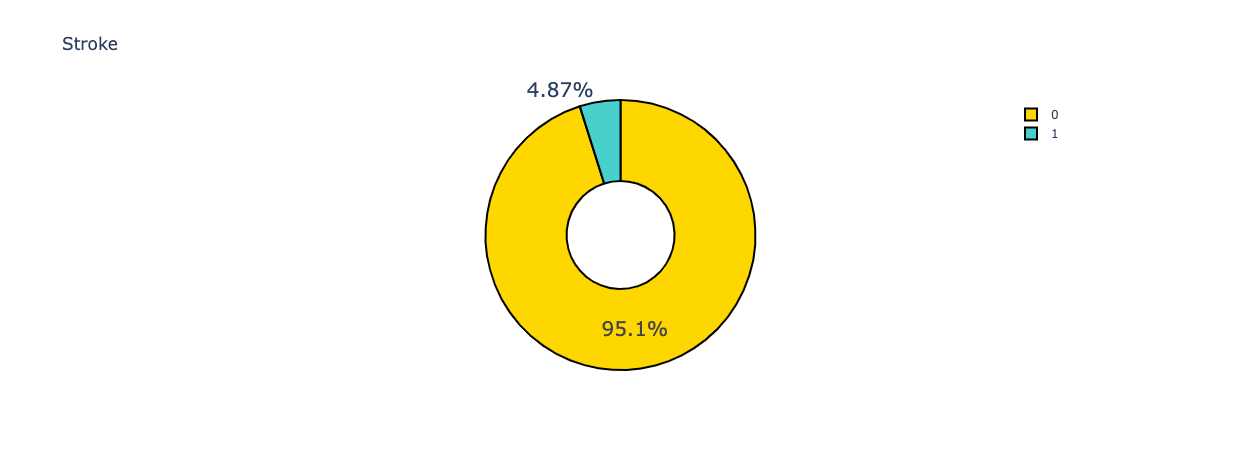

In [89]:
colors = ['gold', 'mediumturquoise']
labels = ['0','1']
values = df['stroke'].value_counts()/df['stroke'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title_text="Stroke", autosize=False)
fig.show()

We can observe that the target is very imbalanced with less than $5\%$ of the samples for which a stroke was registered. And an obvious reason is given by the fact the a stroke is a naturally unbalanced and 'quite rare' occurence, even if it is the second large cause of death worldwide. It is unrealistic to sample data from a group of people and have, for example, a fifty-fifty distribution of people already having had a stroke and people not.

Another reaction could be to say that we do not have enough data. Yet examples are plentyful of why more data is not always more valuable. Let aside, if the data is inaccurate, and by that we mean its characteristics, then the predictions of the model will be wrong too.

So more data for the prediction problem at hand is detrimental for the model's performance if much of that data is not representative of reality to the risk of strokes we are trying to predict.
Specifically, we should not add more data about stroke patients into the dataset because it would not be representative. 

**Note:** we make a big assumption here that the dataset is accurrate to the real world.

However, like we stated earlier, in this case we can argue that the stroke patients are data anomalies in our observation, which are predictive of strokes. Hence, having a much lower proportion of them is not bad...

---
*There is increasingly a push to gather more data across all domains. While more data in and of itself is not a bad thing — it should not be assumed that blindly introducing more data into a model will improve its accuracy.*

*Rather, data scientists still need the ability to determine the relevance of such data to the problem at hand. From this point of view, model selection becomes somewhat of an afterthought. If the data is representative of the problem that you are trying to solve in the first instance, then even the more simple machine learning models will generate strong predictive results.*

### Preprocessing

The the scikit-learn implementation does not support categorical variables so these need to be encoded.
We employ two encoding methods, depending on the kind of categorical variable:
* **Ordinal encoding:** Each feature class is simply assigned an integer value. We apply it on ordinal variables.
* **One-hot encoding:** This is better to use for nominal (i.e. non-ordinal) data. It could otherwise be misleading to the model if we use the integer encoding for features without ordinal relationship. There are some drawbacks but since the number of categories per feature is quite small (max. 5 for *work_type*) we should be safe to use it. [Reference](https://medium.com/geekculture/encoding-categorical-variables-bae06a354cad).

**Note:** we do not encode the features *hypertension* and *heart_disease* since they are already represented numerically with 0 and 1.

In [90]:
vars_ordinal_encoding = ['smoking_status']
vars_onehot_encoding = ['gender', 'ever_married', 'work_type', 'Residence_type']

We create a copy of the dataframe ```df```, ```df_modeling```, that is used for the predictive analysis. ```df```is used for descriptive analysis.

In [91]:
df_modeling = df.copy()

In [92]:
# OneHot encoding of nominal variables
#from sklearn.preprocessing import OneHotEncoder
#
#for var in vars_onehot_encoding:
#    # Convert Pandas Series to Numpy Array for compatibility with encoder.
#    data = df_modeling[var].to_numpy().reshape(-1, 1)
#    # Encoding
#    encoder = OneHotEncoder(sparse=False)
#    onehot = encoder.fit_transform(data)

for var in vars_onehot_encoding:
    # Get one hot encoding of columns B
    onehot = pd.get_dummies(df_modeling[var])
    # Drop column B as it is now encoded
    df_modeling = df_modeling.drop(var, axis=1)
    # Join the encoded df
    df_modeling = df_modeling.join(onehot)

In [93]:
# Ordinal encoding of ordinal variables
from sklearn.preprocessing import OrdinalEncoder

for var in vars_ordinal_encoding:
    # Convert Pandas Series to Numpy Array for compatibility with encoder.
    data = df_modeling[var].to_numpy().reshape(-1, 1)

    # Encoding
    encoder = OrdinalEncoder()
    oe = encoder.fit_transform(data)
    
    # Convert back to Pandas Series
    series = pd.Series(oe.flatten())
    series.index = df.index
    
    df_modeling[var] = series

After label encoding the DataFrame looks like this:

In [94]:
df_modeling.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,Female,Male,No,Yes,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
id,,,,,,,,,,,,,,,,,,
9046,67.0,0,1,228.69,36.600000,1.0,1,0,1,0,1,0,0,1,0,0,0,1
51676,61.0,0,0,202.21,29.065758,2.0,1,1,0,0,1,0,0,0,1,0,1,0
31112,80.0,0,1,105.92,32.500000,2.0,1,0,1,0,1,0,0,1,0,0,1,0
60182,49.0,0,0,171.23,34.400000,3.0,1,1,0,0,1,0,0,1,0,0,0,1
1665,79.0,1,0,174.12,24.000000,2.0,1,1,0,0,1,0,0,0,1,0,1,0


In [95]:
#df['gender'] = df['gender'].replace({'Male':0, 'Female':1})
#df['ever_married'] = df['ever_married'].replace({'Yes':1, 'No':0})
#df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2})
#df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1})
#df['smoking_status'] = df['smoking_status'].replace({'never smoked':0,'Unknown':1,'formerly smoked':2,'smokes':-1})

### Train/Validation/Test split

Split the dataframe in a feature matrix ```df_x``` with 10 input variables and a target vector ```df_y```.

In [96]:
df_X = df_modeling.drop(columns=['stroke'])
df_y = df_modeling['stroke']

Putting a testing set aside for post-development model testing.
We use the ```train_test_split``` function from ```scikit-learn``` to randomly split the dataset. Since the function only splits a dataset's feature matrix and label vector into two we apply it twice to get the desired *train/val/test*-split.

* **Train:** Data set model uses to learn and calibrate its parameters. 
* **Valid:** Like a pre-test set used to evaluate the model fitted on training data and tweak the model's hyperparameters.
* **Test:** Used to evaluate the *final* model.

To achieve such a split we employ a simple random split using two successive calls of ```train_test_split```, where we:
1. Split dataset into *train* and *test*; and
2. Cut a *validation* subset from the *train* data.

The following code snippet produces the split with proportions:
* train: 75%
* validation: 15%
* test: 10%

([Reference on stackexchange](https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn) for data set splitting)

**Note:** The parameter ```stratify = df_y``` ensures an equal proportion of the target class *stroke* in the resulting samples as in the complete dataset when splitting randomly. <br>
This is especially important in our case since our target class is unbalanced.
Otherwise, merely taking random samples may yield a different target class distribution in the train and validation sets then what stratified sampling may yield.

In [97]:
train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=test_ratio, 
    stratify = df_y,
    random_state=42 # 'random_state' controls the shuffling
) 
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_ratio/(val_ratio + train_ratio),
    #shuffle=False # no reason to shuffle again
    stratify = y_train
)

#xxx = ['avg_glucose_level', 'bmi', 'age']
#X_train = X_train[xxx]
#X_val = X_val[xxx]

print(f'Train set size: {len(y_train) / len(df):.4f}')
print(f'Validation set size: {len(y_val) / len(df):.4f}')
print(f'Test set size: {len(y_test) / len(df):.2f}')

Train set size: 0.7499
Validation set size: 0.1501
Test set size: 0.10


#### Distribution comparison Training & Validation
We check if the *training* set and *validation* set follow the same distribution by means of a **Q-Q plot** for features *age*, *bmi*, and *avg_glucose_level*.

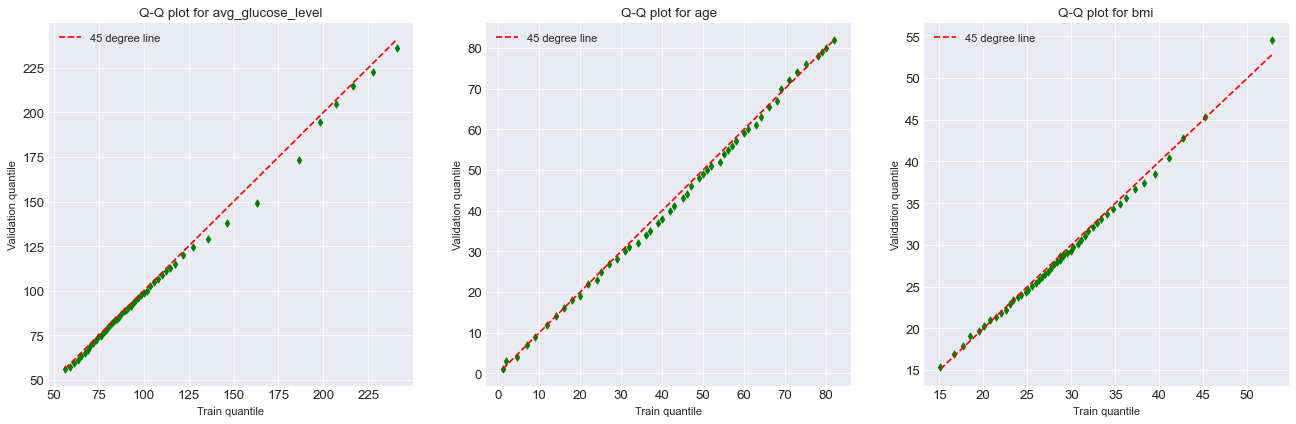

In [98]:
# Are these two datasets from the same distribution? 

# Calculate quantiles for these two datasets
qs = [q*0.01 for q in range(1, 100, 2)]
quantiles = {
    "avg_glucose_level": pd.DataFrame({
        "train": X_train['avg_glucose_level'].quantile(qs),
        "validation": X_val['avg_glucose_level'].quantile(qs)
        }),
    "age": pd.DataFrame({
        "train": X_train['age'].quantile(qs),
        "validation": X_val['age'].quantile(qs)
        }),
    "bmi": pd.DataFrame({
        "train": X_train['bmi'].quantile(qs),
        "validation": X_val['bmi'].quantile(qs)
        })
    }

fig, axes = plt.subplots(nrows=1, ncols=len(quantiles), figsize=(20,6), dpi=80)

for idx, (ax, feature) in enumerate(zip(axes.flatten(), quantiles)):
  # Plot 45-degree line on subplots
  ax.plot(quantiles[feature]["train"], quantiles[feature]["train"], color='r', linestyle="dashed", label="45 degree line")
  # Plot train & test quantiles of features
  quantiles[feature].plot.scatter(x="train", y="validation", ax=axes[idx], marker="d", color="green", fontsize=12)

  axes[idx].set_xlabel("Train quantile")
  axes[idx].set_ylabel("Validation quantile")
  axes[idx].legend()
  axes[idx].set_title(f"Q-Q plot for {feature}");

## 2. Problem Definition

- **Problem** : We use a dataset containing personal medical data from patients with an indication if
whether or not they already suffered a stroke in the past. We are trying to predict if a given patient
has a risk of having a stroke.
- Use Case : The reason to build such a model is important because according to the World Health
Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately
11% of total deaths.Reference. Doctors and hospitals are the only environment (maybe big tech also)
in which such a model could be utilized since it contains medical information from patients.
- **Dataset** : The dataset comes from kaggle. However, we do not know the true origin of the dataset.
The reason is probably because of privacy and ethical reasons. The data records were probably
aggregated at a regional hospital or doctor’s practice since it is not that big.
- **Target Users** : Predictive Model Both doctors and patients are the first target users of this
predictive model that come to mind. They both work in tandem to provide and collect through a
medical check the required (personal and sensitive) information about the patient. However, there
are privacy considerations since the dataset contains medical data and the patient should give his/her
informed consent to the data controller who holds the responsibility for compliance with the local
privacy law (i.e. GDPR in the EU).
- **A Good Prediction** : In the case of prevention, it is better to have false positives than false negatives.
If you find a risk of stroke and it turns out not to be the case, it’s not a big deal. But on the contrary,
we do not want a stroke to occur when it was not predicted. Prevention is better than cure. The
doctor wants his patient to be healthy. However, if the target user was an insurance company, we
would have wanted very precise data, so we would also have sought to minimise false positives.

## 3. Descriptive analysis

We begin by manually dividing the features into their respective type and plotting histograms for both types.

In [99]:
features_cat = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
features_num = ['age', 'avg_glucose_level', 'bmi']

In [100]:
#feature_names = [cname for cname in df.drop(columns=['stroke', 'age', 'gender','hypertension', 'heart_disease']).columns]
#
#sns.set(font_scale = 2)
#sns.set_style("white")
#sns.set_palette("bright")
#plt.subplots_adjust(hspace=0.5, wspace=0.3)
#for idx, name in enumerate(feature_names):
#    plt.subplot(len(feature_names),1,idx+1)
#    sns.histplot(data=df, x=name, hue="stroke", kde=True, palette="YlGnBu")

### Numerical Features

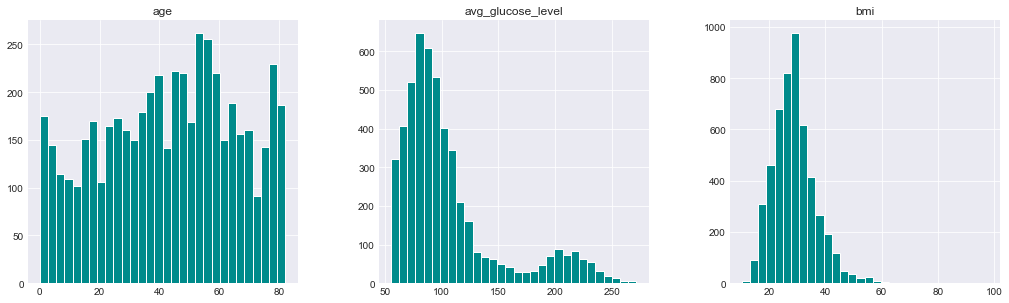

In [101]:
df.hist(column=features_num, bins=30, 
        layout=(5,5), figsize=(30, 30), color="DarkCyan")
plt.show()

* Data distribution for *age* has dominant values around: $10, 60$ & $80$.
* *avg_glucose_level* has 2 peaks of uneven heights present at values around: $100$ and $200$.
* *bmi* has a near about normal distribution but it has values in low numbers towards the right side!

#### w.r.t Stroke

* For 'age', cases of 'stroke suffered' can be observed for the values between 35 - 80. It is not a dominant patch due to the imbalance nature of the dataset.
* For 'avg_glucose_level', 2 groups can be found : 60 - 100 & 180 - 220. Patients with 'avg_glucose_level' present in the 1st group are more prone to suffering stroke than group 2.
* *bmi* values from 15 - 40 have displayed more cases of stroke.

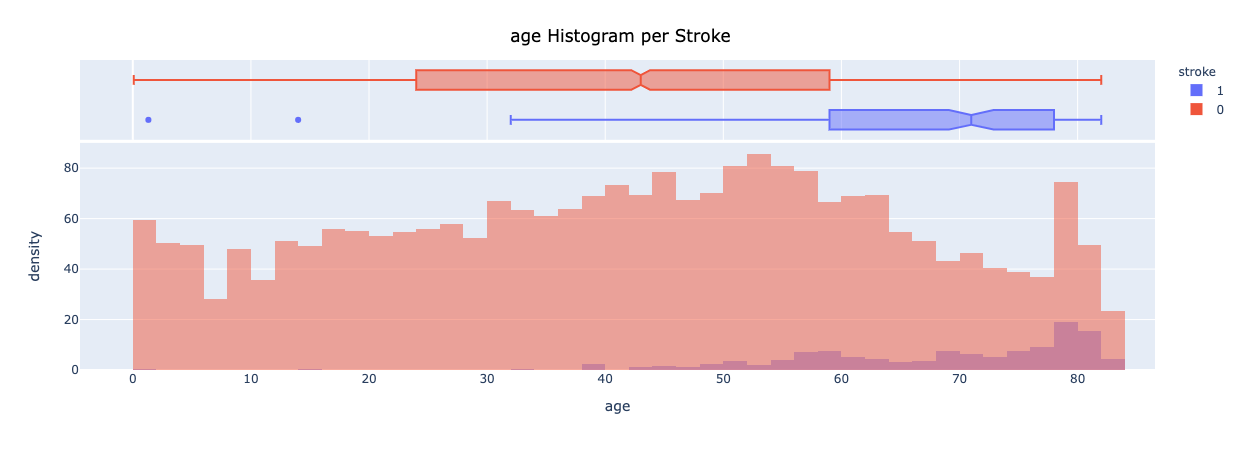

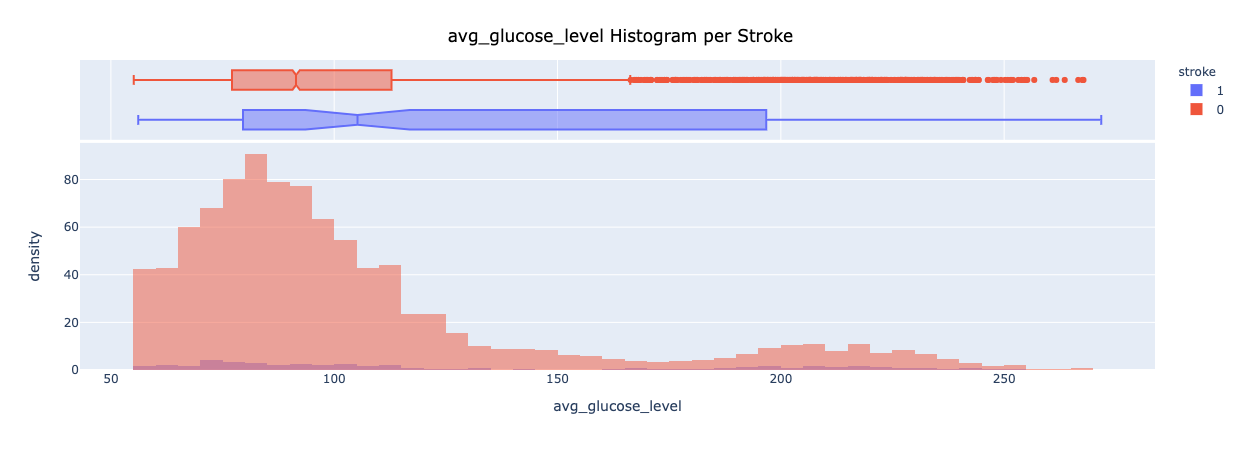

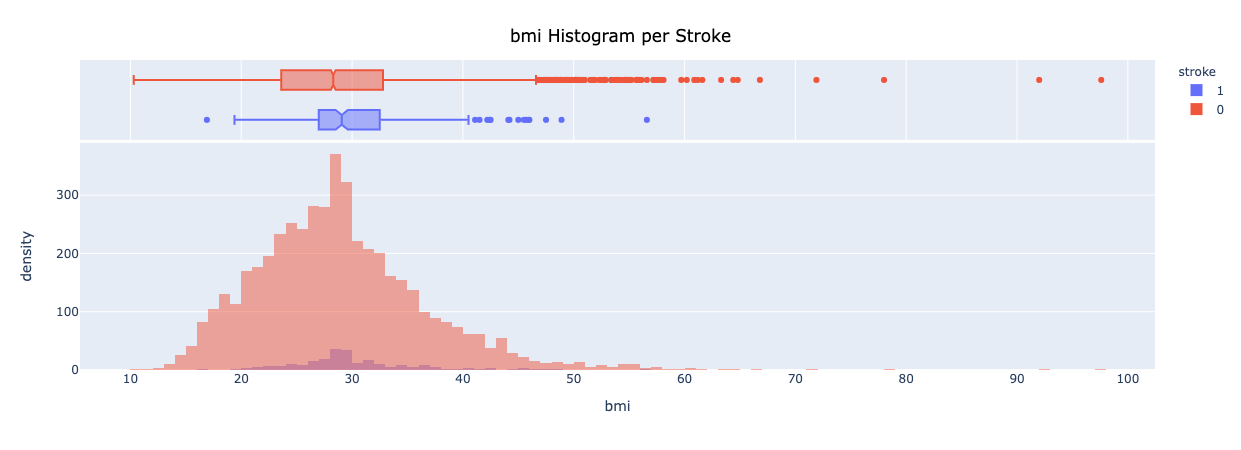

In [102]:
import plotly.express as px
from plotly.subplots import make_subplots

variables = ['age', 'avg_glucose_level', 'bmi']

for feature in variables:
    hist = px.histogram(
        df, x=feature,
        color="stroke", marginal="box", barmode ="overlay", histnorm ='density'
    )
    hist.update_layout(
        title_font_color="black",
        title={
            'text': f"{feature} Histogram per Stroke",
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'}
    )
    hist.show()

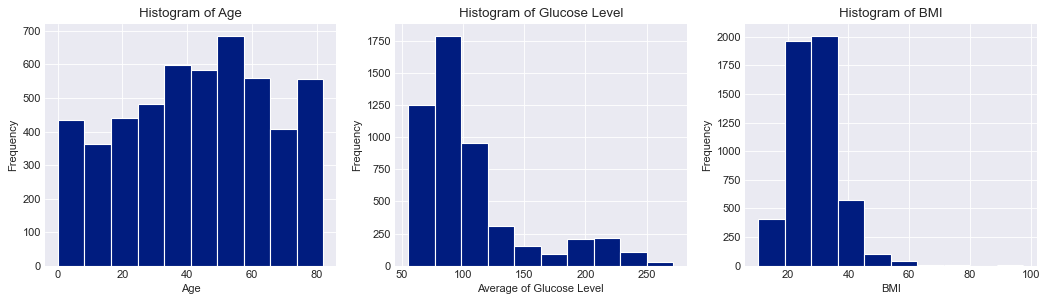

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4), dpi=80)

df_X['age'].plot.hist(ax=axes[0])
df_X['avg_glucose_level'].plot.hist(ax=axes[1])
df_X['bmi'].plot.hist(ax=axes[2])

# Plot Labeling
axes[0].set_title("Histogram of Age")
axes[0].set_xlabel("Age")
axes[1].set_title("Histogram of Glucose Level")
axes[1].set_xlabel("Average of Glucose Level")
axes[2].set_title("Histogram of BMI")
axes[2].set_xlabel("BMI")

plt.show()

### Categorical Features

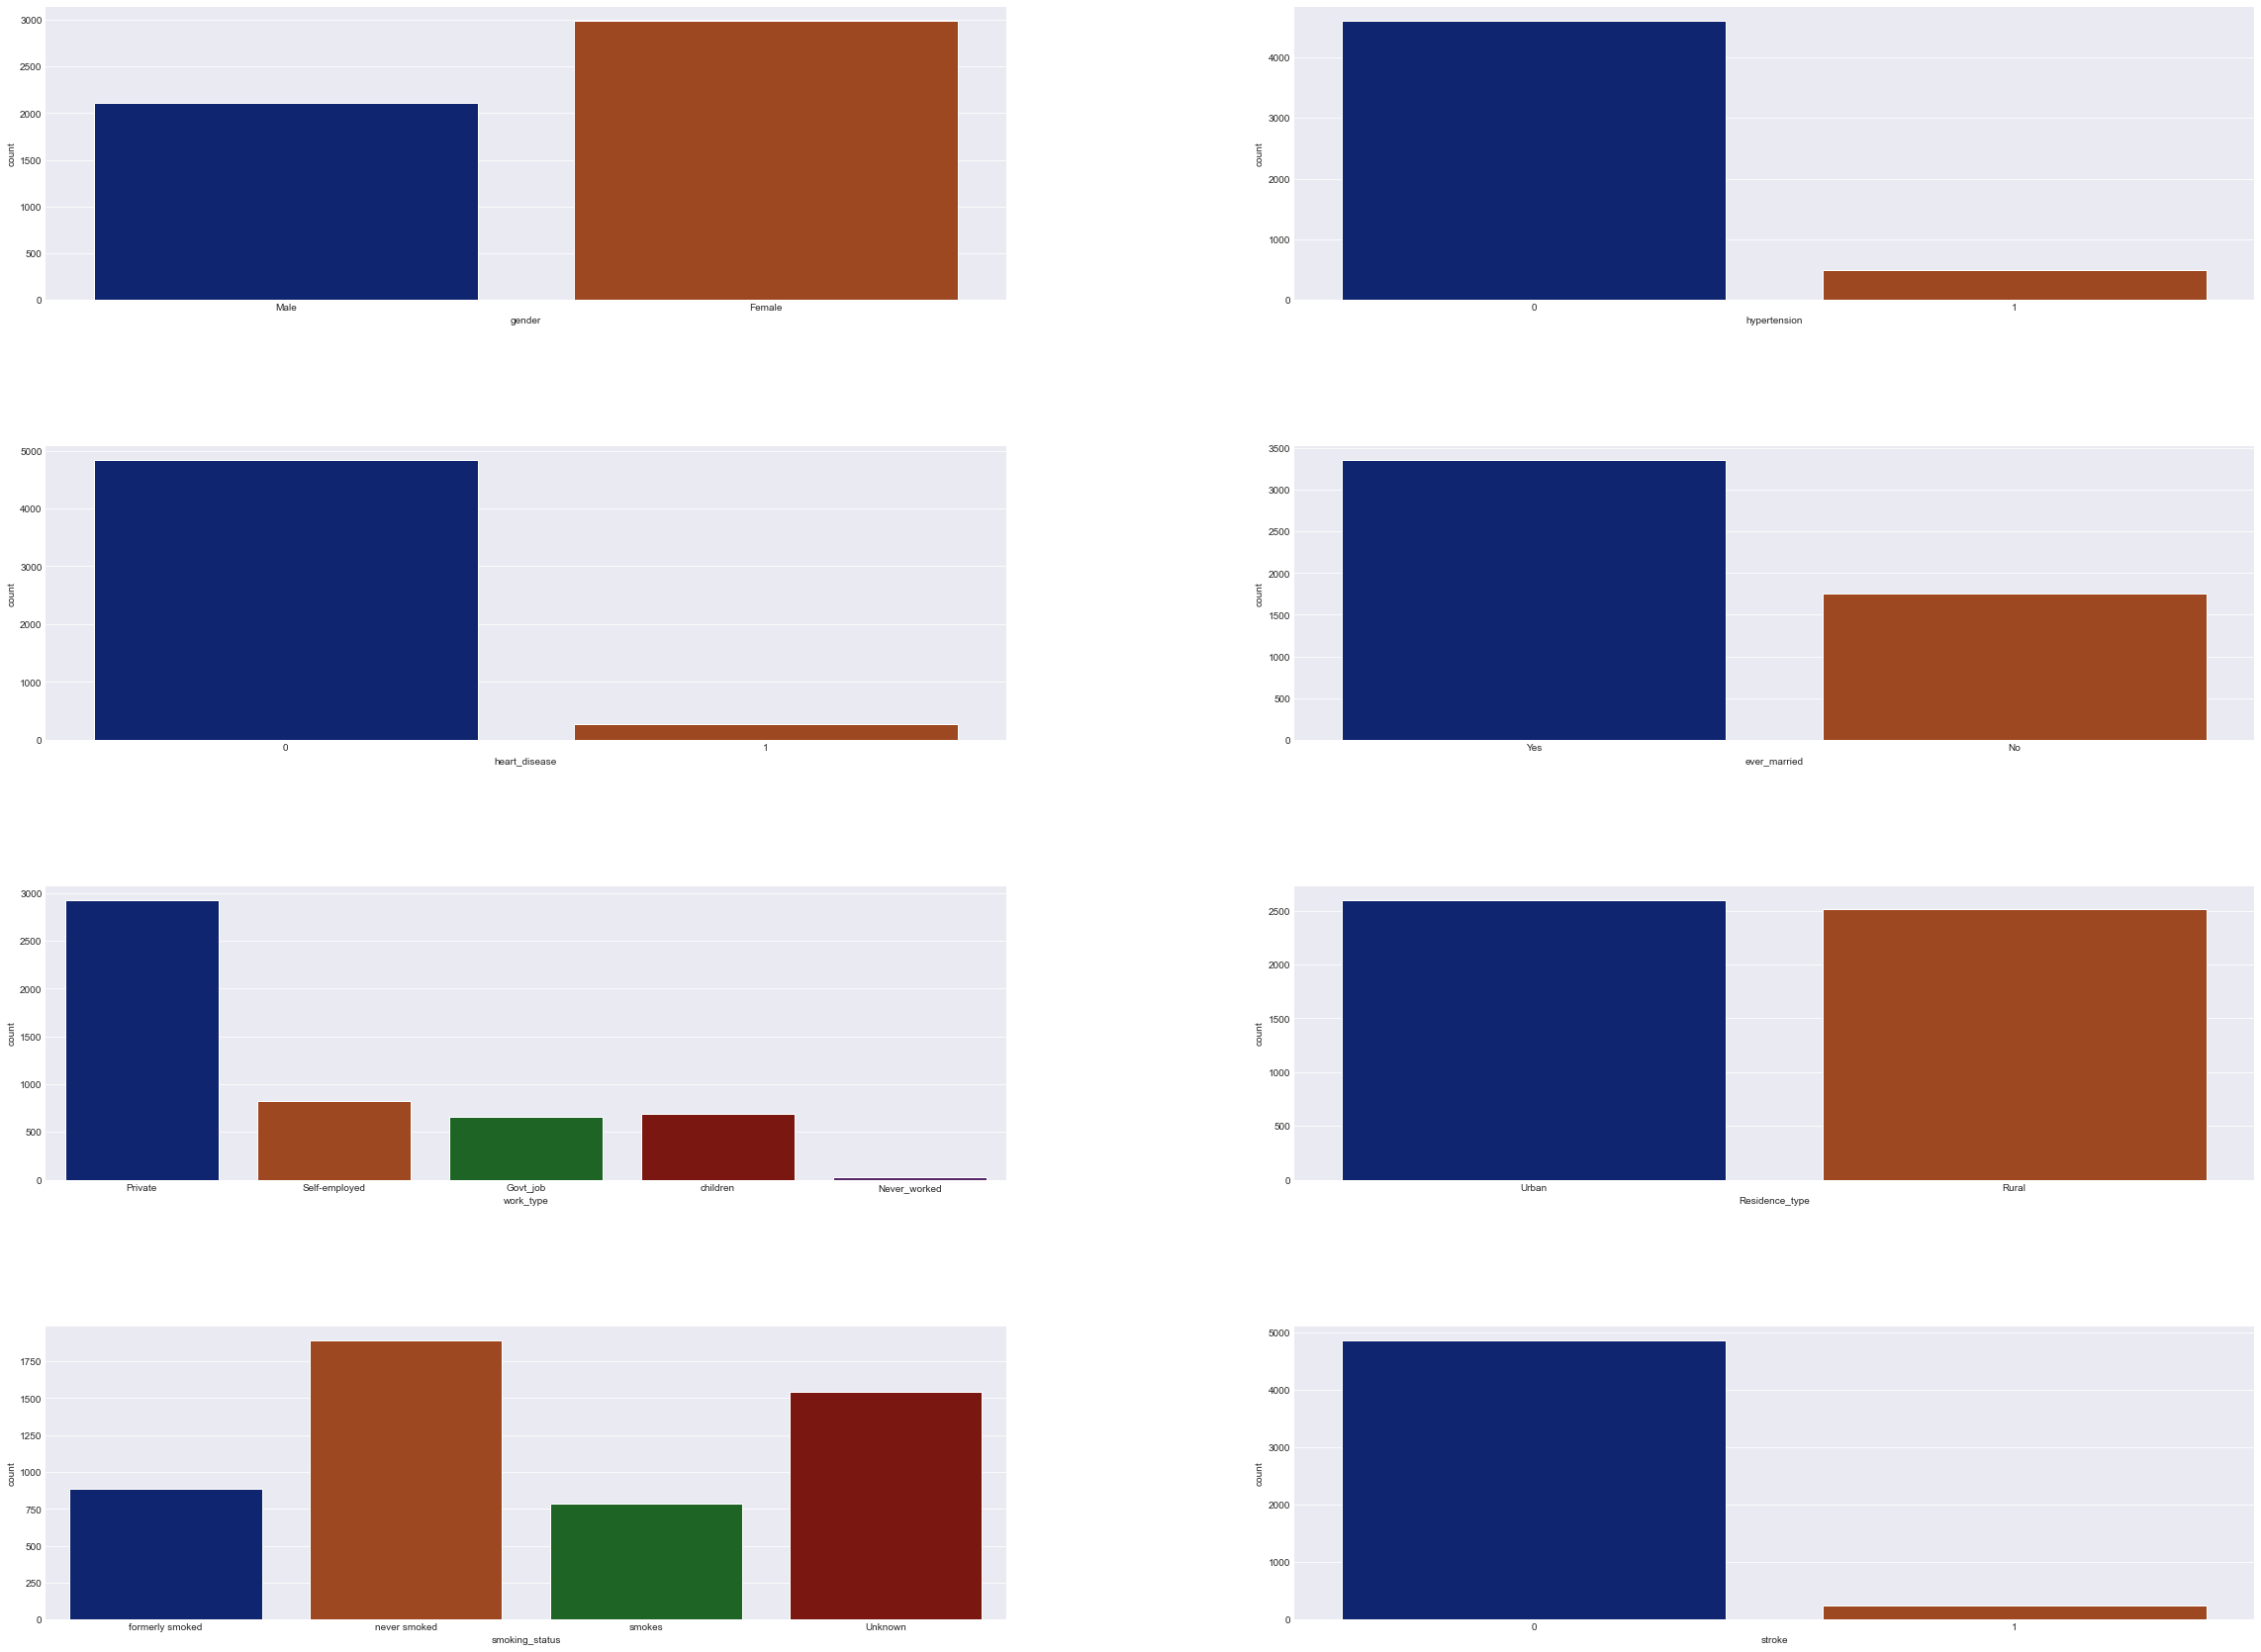

In [104]:
fig,axes = plt.subplots(4,2,figsize=(40, 30))

sns.set_style("white")
sns.set_palette("dark")
#fig.suptitle("Count plot for various categorical features")

plt.subplots_adjust(hspace=0.5, wspace=0.3)

sns.countplot(ax=axes[0,0],data=df,x='gender')
sns.countplot(ax=axes[0,1],data=df,x='hypertension')
sns.countplot(ax=axes[1,0],data=df,x='heart_disease')
sns.countplot(ax=axes[1,1],data=df,x='ever_married')
sns.countplot(ax=axes[2,0],data=df,x='work_type')
sns.countplot(ax=axes[2,1],data=df,x='Residence_type')
sns.countplot(ax=axes[3,0],data=df,x='smoking_status')
sns.countplot(ax=axes[3,1],data=df,x='stroke')

plt.show()

In [105]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.892790,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.698351,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Dependence of some selected variables

In [106]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'avg_glucose_level', 'bmi']

### Correlation
To measure correlation for numerical x numerical data, we can use correlation matrix

In [107]:
# creation of correlation matrix
corrM = df_X[numerical_features].corr()
corrM

,age,avg_glucose_level,bmi
age,1.000000,0.238323,0.325823
avg_glucose_level,0.238323,1.000000,0.168785
bmi,0.325823,0.168785,1.000000


#### Categorical and Categorical
To measure correlation for **categorical** x **categorical** data, we can use chi-square metric

https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626

In [108]:
def chi_square_test(df, feature1, feature2) :
    # create contingency table
    data_crosstab = pd.crosstab(df[feature1], df[feature2], margins=True, margins_name="Total")

    # Calcualtion of Chisquare
    chi_square = 0
    rows = df[feature1].unique()
    columns = df[feature2].unique()
    for i in columns:
        for j in rows:
            O = data_crosstab[i][j]
            E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
            chi_square += (O-E)**2/E
    
    p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))

    alpha = 0.05
    if p_value <= alpha:
        # Null Hypothesis is rejected.
        res = True
    else :
        # Failed to reject the null hypothesis
        res = False

    return(res)

In [109]:
matrix_chi2 = pd.DataFrame(index=categorical_features, columns=categorical_features)

for feature1 in categorical_features :
    for feature2 in categorical_features :
        matrix_chi2[feature1][feature2] = chi_square_test(df, feature1, feature2)

matrix_chi2

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
gender,True,False,True,True,True,False,True
hypertension,False,True,True,True,True,False,True
heart_disease,True,True,True,True,True,False,True
ever_married,True,True,True,True,True,False,True
work_type,True,True,True,True,True,False,True
Residence_type,False,False,False,False,False,True,False
smoking_status,True,True,True,True,True,False,True


#### Numerical and Categorical
To measure correlation for **numerical** x **categorical** data, we can use inter and intra deviation

In [110]:
def calculate_correlation_ratio(df, numerical_feature, categorical_feature):

    n = df.shape[0]
    numerical_feature_mean = df[numerical_feature].mean()

    inter_deviation = 0
    intra_deviation = 0

    categories = df[categorical_feature].unique()

    for k in categories:
        nk = df.loc[df[categorical_feature] == k].shape[0]
        standard_deviation = df.loc[df[categorical_feature] == k, numerical_feature].std()
        if standard_deviation >= 0:
            intra_deviation += nk * standard_deviation
        inter_deviation += nk * pow(df.loc[df[categorical_feature] == k, numerical_feature].mean() - numerical_feature_mean, 2)

    inter_deviation *= 1/n
    intra_deviation *= 1/n
    total_deviation = inter_deviation + intra_deviation

    return(inter_deviation / total_deviation)

In [111]:
matrix_correlation_ratio = pd.DataFrame(index=categorical_features, columns=numerical_features)

for feature1 in numerical_features :
    for feature2 in categorical_features :
        matrix_correlation_ratio[feature1][feature2] = calculate_correlation_ratio(df, feature1, feature2)

matrix_correlation_ratio

,age,avg_glucose_level,bmi
gender,0.017129,0.119632,0.005478
hypertension,0.643944,0.585136,0.16668
heart_disease,0.62133,0.54717,0.011394
ever_married,0.934439,0.529569,0.479189
work_type,0.937496,0.372363,0.631809
Residence_type,0.004431,0.001035,0.0
smoking_status,0.799737,0.329885,0.363566


##### Dependance between features and target class

In [112]:
features = categorical_features + numerical_features

matrix_correlation_with_target = pd.DataFrame(index=features, columns=['stroke'])

for index, feature in enumerate(features) :
    if feature in categorical_features :
        matrix_correlation_with_target.iloc[index] = chi_square_test(df, feature, 'stroke')
    else :
        matrix_correlation_with_target.iloc[index] = calculate_correlation_ratio(df, feature, 'stroke')

matrix_correlation_with_target

,stroke
gender,False
hypertension,True
heart_disease,True
ever_married,True
work_type,True
Residence_type,False
smoking_status,True
age,0.584851
avg_glucose_level,0.444015
bmi,0.011502


Polting dependence

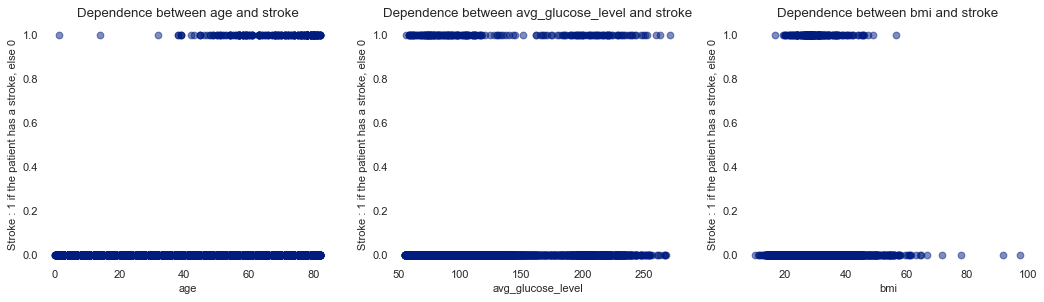

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4), dpi=80)
for idx,feature in enumerate(numerical_features):
    axes[idx].scatter(df[feature], df['stroke'], alpha=0.5)
    axes[idx].set_title(f"Dependence between {feature} and stroke")
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Stroke : 1 if the patient has a stroke, else 0")
plt.show()

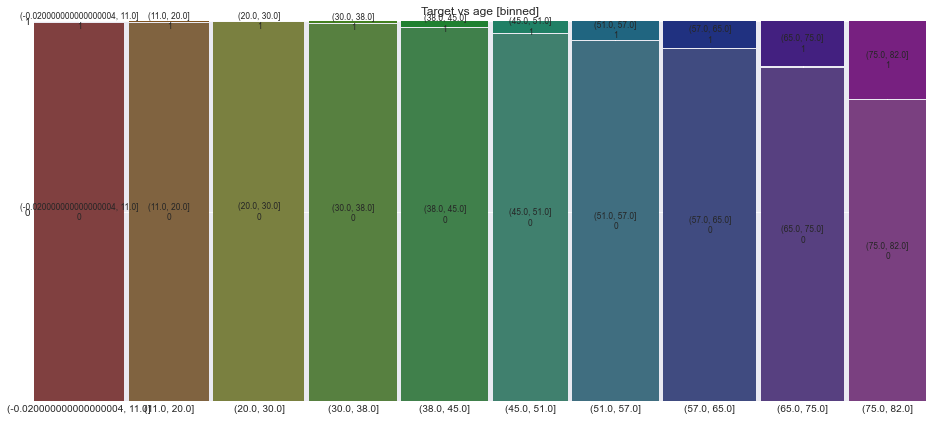

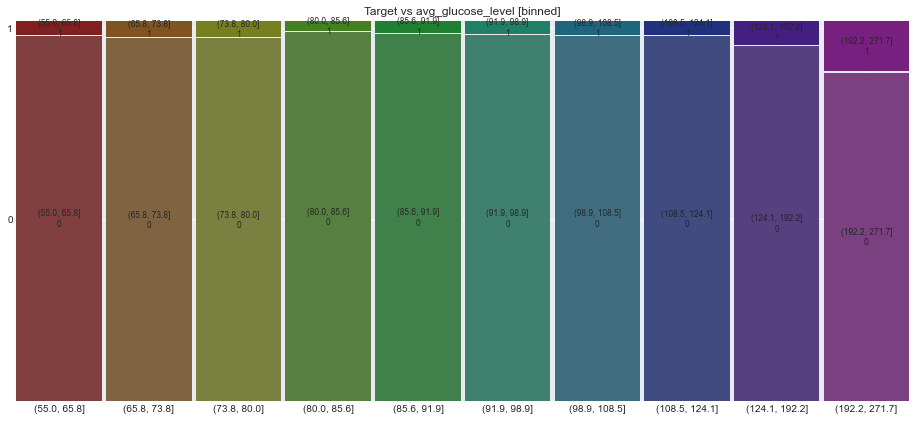

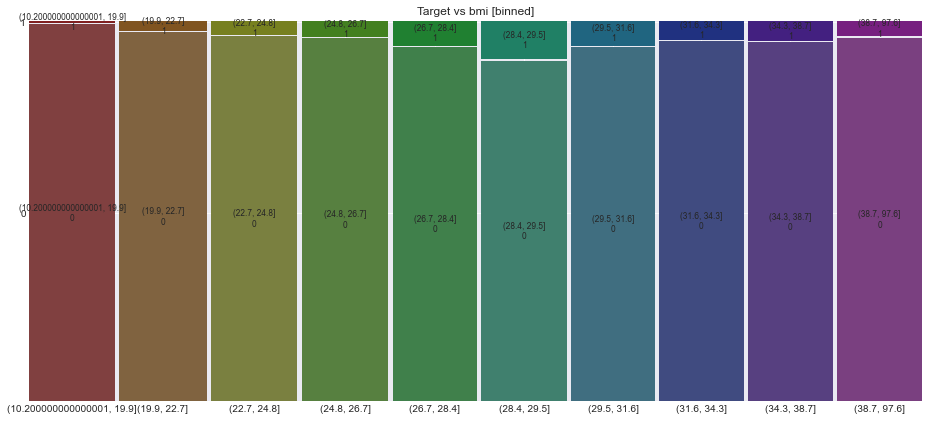

In [138]:
# add binned version of numerical features

# quantile based:
df['age_bin'] = pd.qcut(df['age'], q=10, precision=1)
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

# plot target vs features using mosaic plot
#plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in numerical_features:
    f_bin = f+'_bin'
    plt.rcParams["figure.figsize"] = (16,7) # increase plot size for mosaics
    mosaic(df, [f_bin, 'stroke'], title='Target vs ' + f + ' [binned]')
    plt.show()
    
# reset plot size again
plt.rcParams['figure.figsize'] = plt_para_save

We can see a good correlation with the age

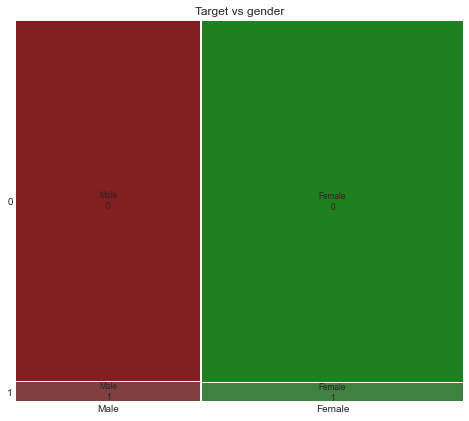

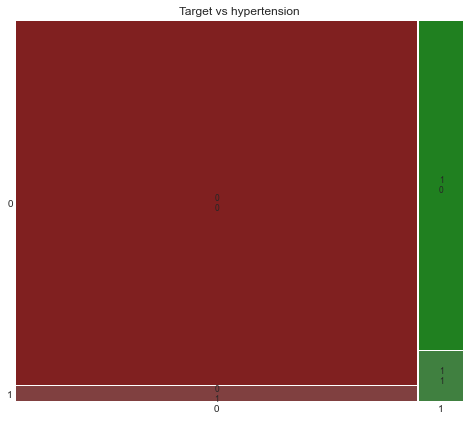

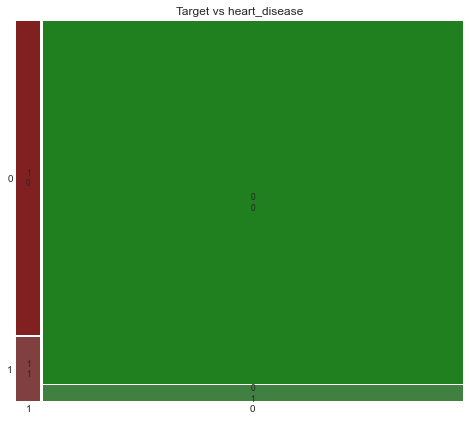

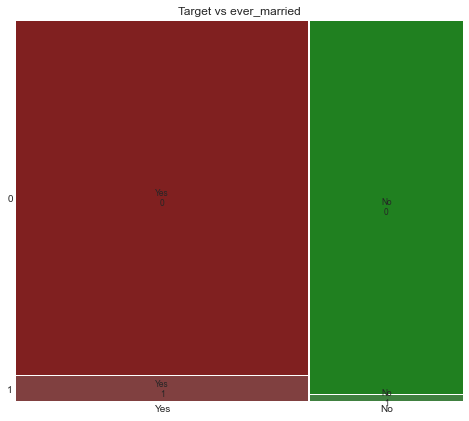

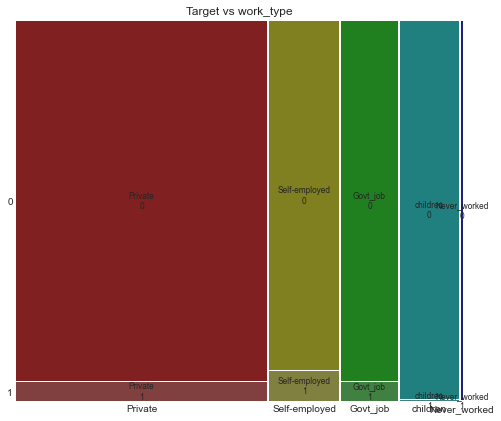

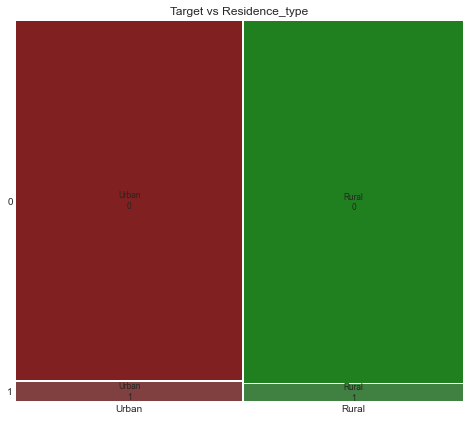

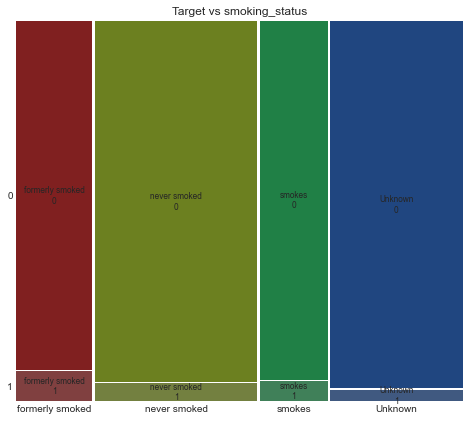

In [115]:
# plot target vs features using mosaic plot
plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in categorical_features:
    plt.rcParams["figure.figsize"] = (8,7) # increase plot size for mosaics
    mosaic(df, [f, 'stroke'], title='Target vs ' + f)
    plt.show()
    
# reset plot size again
plt.rcParams['figure.figsize'] = plt_para_save

Target variable has a good correlation with hypertension and heart_disease

## 4. Probability Distribution

We choose to use probabiblity distribution for describe variables we chose for the prediction :

* *age*
* *avg_glucose_level*
* *bmi*
* *hypertension*
* *heart_disease*
We use the Kernel Density Estimator (KDE) technique to estimate probability density.

The variables *age*, *avg_glucose_level* and *bmi* are numerical, then we can try to describe them with a gaussian distribution. Firstly, we set the parameters with the calculated mean and standard deviation.

**TODO: Explanation**

To verify if the variables and the estimated pdf follow the same distribution, we can use a **Q-Q plot**.

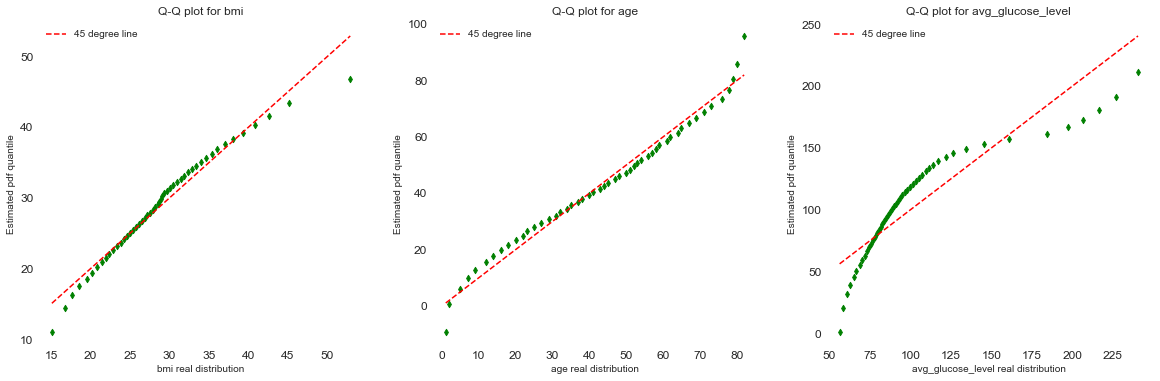

In [117]:
fig, ax = plt.subplots(1, len(features), figsize=(20,6))

for idx, feature in enumerate(features):
        # Estimation of the Gaussian parameters
        estimated_mean_all = df[feature].mean()
        estimated_std_all = df[feature].std()

        qs = [q*0.01 for q in range(1, 100, 2)]
        real_data = df[feature].quantile(qs) 
        estimated_pdf = stats.norm.ppf(qs, loc=estimated_mean_all, scale=estimated_std_all)

        quantiles = pd.DataFrame({"real_data": real_data, "estimated_pdf": estimated_pdf})

        quantiles.plot.scatter(x="real_data", y="estimated_pdf", ax=ax[idx], marker="d", color="green", fontsize=12)

        ax[idx].plot(quantiles["real_data"], quantiles["real_data"], color='r', linestyle="dashed", label="45 degree line")
        ax[idx].set_xlabel(feature + " real distribution")
        ax[idx].set_ylabel("Estimated pdf quantile")
        ax[idx].legend()
        ax[idx].set_title("Q-Q plot for " + feature);
                
plt.show()

For *age* and *bmi* it is approximatively the same distribution, but not for the *avg_glucose_level*. We need to use a better probability distribution.

Next, the variables *hypertension* and *heart_disease* can be describe by a Bernoulli distribution, with the calculated probability.

* The parameters for a Gaussian distribution are the *mean* $\mu$ and the *standard deviation* $\sigma$.
* The parameter for Bernoulli distribution is the probability of success.

To estimate these parameters, we can use the maximum likelihood estimation (MLE).

**TODO: explanation** 

In [53]:
# Reference: from lectures

# likelihood function for gaussian distribution
def neg_log_likelihood_gaussian(params, data):
  mu = params[0]
  sigma = params[1]
  n = len(data)
  
  # likelihood calculation
  normalization = (2 * np.pi * sigma**2)**(-n/2)
  exp_term = np.exp(-1 / (2 * sigma**2) * np.sum((data - mu)**2))
  likelihood = normalization * exp_term
  
  # negative likelihood
  return -likelihood

def estimate_parameters_MLE(df, feature, distribution):
  # parameters initialization
  if distribution == 'gaussian':
    mu_init = np.mean(df[feature])
    sigma_init = np.std(df[feature])
    params_init = [mu_init, sigma_init]

    # likelihood optimization
    results = sp.optimize.minimize(neg_log_likelihood_gaussian, params_init, args=(df['age'],))
    mu_ml, sigma_ml = results.x

    return(mu_ml, sigma_ml)

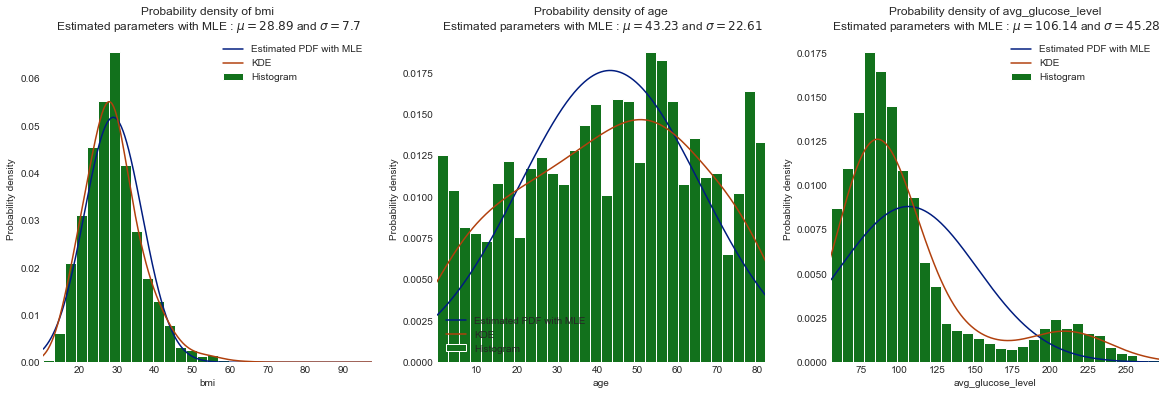

In [54]:
features = ['bmi', 'age', 'avg_glucose_level']
fig, ax = plt.subplots(1, len(features), figsize=(20,6))

# Plotting Histogram and probability density
for idx, feature in enumerate(features):
    # Estimation of the Gaussian parameters
    estimated_mean_all, estimated_std_all = estimate_parameters_MLE(df, feature, 'gaussian')

    # auxiliary variables
    min_feature = df[feature].min()
    max_feature = df[feature].max()
    # Plotting PDF
    x = np.linspace(min_feature, max_feature, num=1000)
    pdf = stats.norm.pdf(x, estimated_mean_all, estimated_std_all)
    ax[idx].plot(x, pdf, label='Estimated PDF with MLE')

    # Plotting KDE
    df[feature].plot.kde(bw_method=0.4, label='KDE', ax=ax[idx])
    
    # Plotting Histogram (Normalized)
    ax[idx].hist(df[feature], bins=30, density=True, label='Histogram')

    ax[idx].set_ylim(ymin=0)
    ax[idx].set_xlabel(f"{feature}")
    ax[idx].set_ylabel("Probability density")
    ax[idx].set_title("Probability density of " + feature + "\n Estimated parameters with MLE : $\mu = " + str(round(estimated_mean_all,2)) + "$ and $\sigma = " + str(round(estimated_std_all,2)) + "$")
    ax[idx].set_xlim(xmin=df[feature].min(), xmax=df[feature].max())

    ax[idx].legend()
plt.show()

### Hypothesis Testing


Confidence intervals are one way to estimate a population parameter. Another way to make a statistical inference is to
make a decision about a parameter.

The purpose of a hypothesis test is to decide whether the null hypothesis is likely to be true given sample data. If there is little evidence against the null hypothesis given the data, you accept the null hypothesis. If the null hypothesis is unlikely given the data, you might reject the null in favor of the alternative hypothesis.

Hence, there are two options for a decision. They are "reject H0" if the sample information favors the alternative hypothesis or "do not reject H0" or "decline
to reject H0" if the sample information is insufficient to reject the null hypothesis. When you perform a hypothesis test, there are four possible outcomes depending on the actual truth (or falseness) of the null hypothesis H0 and the decision to reject or not.

The four possible outcomes in the table are:

1. The decision is not to reject H0 when H0 is true (correct decision).
2. The decision is to reject H0 when H0 is true ( Type I error).
3. The decision is not to reject H0 when, in fact, H0 is false (Type II error).
4. The decision is to reject H0 when H0 is false (correct decision whose probability is called the Power of the Test).

Each of the errors occurs with a particular probability. The Greek letters α and β represent the probabilities.
α = probability of a Type I error = P(Type I error) = probability of rejecting the null hypothesis when the null hypothesis
is true.
β = probability of a Type II error = P(Type II error) = probability of not rejecting the null hypothesis when the null
hypothesis is false.

Using the sample data to calculate the actual probability of getting the test result, called the p-value. The p-value is the
probability that, if the null hypothesis is true, the results from another randomly selected sample 
will be as extreme or more extreme as the results obtained from the given sample. A large p-value calculated from the data indicates that we should not reject the null hypothesis. The smaller the p-value, the more unlikely the outcome, and the stronger the evidence is against the null hypothesis.

A systematic way to make a decision of whether to reject or not reject the null hypothesis is to compare the p-value and a
preset or preconceived α (also called a "significance level"). A preset α is the probability of a Type I error (rejecting the
null hypothesis when the null hypothesis is true).


Null Hypothesis: BMI levels are not significantly different for people with stroke
Alternative Hypothesis: BMI levels are significantly different for people with stroke 

Assumptions: normal distrubution of data

So we want to check how probable sample mean (mu1) of the distrubition of healthy people lies inside the normal distrubition of the people with sample mean (mu 2) 
We are data has normal distribution in both cases

We pick 95% confidence level so our level of significance is α=0.05

H₀: α ≤ p-value or The significance level is equal to or higher than p-value .

Ha: α > p-value or The true mean difference is smaller than ?sigma .

The T-test is used to determine whether a numeric data sample differs significantly from the population or whether two samples differ from one another. A t-test will be conducted at a 95% confidence level and will be observed if it correctly rejects the null hypothesis that the sample comes from the same distribution.

In [121]:
stats.ttest_1samp(a = df[df['stroke'] == 1]['bmi'],               # Sample data
                  popmean = df[df['stroke'] == 0]['bmi'].mean())  # bigger Sample mean

Ttest_1sampResult(statistic=3.7600223997915028, pvalue=0.00021196655808129123)

The test result shows the test statistic "t" is equal to $3.7646477105748923$. This test statistic tells us how much the sample mean deviates from the null hypothesis. If the t-statistic lies outside the quantiles of the t-distribution corresponding to our confidence level and degrees of freedom, we reject the null hypothesis and agree that they differ. We can check the quantiles :

In [122]:
stats.t.ppf(q=0.025,  # Quantile to check
            df=241)  # Degrees of freedom

-1.9698562125951948

In [123]:
stats.t.ppf(q=0.975,  # Quantile to check
            df=241)  # Degrees of freedom

1.9698562125951944

We can calculate the chances of seeing a result as extreme as the one we observed (known as the p-value) by passing the t-statistic in as the quantile to the stats.t.cdf() function:

In [124]:
stats.t.cdf(x= -3.7646477105748923,      # T-test statistic
               df= 241) * 2   # Multiply by two for two tailed test

0.00020959039560406164

The value above is the same value we calculated for p value.

Since result is less than 0.05 it tells us for the means to differ this much is so unlikely (meaning it
is happening NOT by chance alone). Hence, we reject the null hypothesis with confidence level of %95 
and say BMI levels are significantly different for people with stroke according to our data.

We should keep in mind that in some cases when we "do not reject H0", it does not mean that we should believe that H0 is true. It simply means that the sample
data have failed to provide sufficient evidence to cast serious doubt about the truthfulness of Ho.



**2nd Hypothesis test**

In this second Hypothesis test we want to compare the effect of gender on this morbid condition. OurSet up can be seen below. 

Null Hypothesis: There is no relationship between gender and having a stroke
Alternative Hypothesis: There is a relationship between gender and having a stroke

Chi-square tests are ideally suited to a data set in which both the variables to be compared are categorical.The Chi-square test is used to check whether the two characteristics are independent. It is used to determine whether a categorical outcome variable (Y) is related or associated with another categorical predictor variable (X)

Assumptions:

>The sample is drawn randomly from the population.

>Data is to be reported in raw frequencies (counts, not percentages)

>Observations are independent

>Variables are mutually exclusive (individuals cannot be assigned to more than one category) and exhaustive (include all possible contexts or categories)


Observed frequencies are not too small (n must be relatively large) in a 2 x 2 table; Chi-Square should not be used if n is less than 20 or any of the individual cell counts is less than 5



In [126]:
#----------step 1: Extract columns of categorical data you want to compare
data_interim=df[['gender', 'stroke']]
#----------step 2: Create a contigency table by crosstab
data_cont=pd.crosstab(data_interim['gender'], data_interim['stroke'])
data_cont
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_cont)

#-----------interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    
    print('p <= alpha ===> Hence Dependent. There is a relationship between gender and having a stroke(reject H0)')
    
else:
    print('p < alpha  ===> Hence, Independent. There is no relationship between gender and having a stroke (H0 holds true)')

p value is 0.5598277580669416
p < alpha  ===> Hence, Independent. There is no relationship between gender and having a stroke (H0 holds true)


According to result above, we can say that with data sample in our hand we concluded that gender has nospecific role in stroke.

## 5. Predictive Analysis

We are working on a classification problem for **stroke prediction** to predict the likelihood of a stroke for a new patient.

* **Positive class:** "stroke" (smaller class)
* **Negative class:** "no stroke" (larger class)

**Evaluation Metric:** <br>
Since the measurements are imbalanced and contain more negative data ($\approx 95\%$) than positive data ($\approx 5\%$), we use the **precision** and **recall** evaluation metrics. They are more sensitive to getting the positive class (i.e. a stroke) right. Moreover we look at the **F1-score** which is a combination of the former two metrics. **Accuracy** would be a very bad choice because in $95\%$ of the time our model would correctly predict the negative class since it is dominant.

Since we are in a medical context we need to try to reduce the *false negatives (FN)*. However, it should not be a problem to have too many *false positives (FP)*. A *false negative (FN)* diagnosis on the other hand falsely reassures a doctor and patient that there is no risk for a stroke. <br>
**Precision** tells us how often the model was right when it classifies an instance as positive (i.e. having a stroke). We do not bother having particularly high precision since *false positives* are not that worrisome for our case.<br>
**Recall** tells us how often the model was right on all positive instances. And since we want to reduce the *false negatives* as much as possible we want to achieve ***high recall***.

---

Plotting the three numerical features in 3D space can indicate whether or not stroke and non-stroke samples are separable by means of these features.

As illustrated below there is no clear separation so we train the model using the categorical features as well.

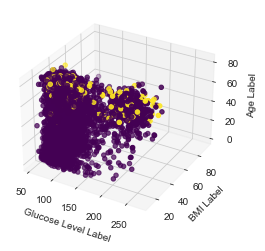

In [39]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
xdata = X_train['avg_glucose_level']
ydata = X_train['bmi']
zdata = X_train['age']
ax.scatter3D(xdata, ydata, zdata, c=y_train, cmap='viridis');
ax.set_xlabel('Glucose Level Label')
ax.set_ylabel('BMI Label')
ax.set_zlabel('Age Label')
plt.show()

### Model 1: Support Vector Machine

In [40]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder

# Create the model 
#svm_pipeline = Pipeline(steps = [('scale',StandardScaler()), ('SVM',svm.SVC(random_state=42,probability=True))])
svm_pipeline = Pipeline(steps = [('SVM',svm.SVC(kernel='linear', random_state=42,probability=True))])

...

In [41]:
from sklearn.model_selection import cross_val_score

#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
#svm_cv = cross_val_score(svm_pipeline, X_train, y_train, cv=10, scoring='f1')
#svm_cv.mean()

In [42]:
svm_pipeline.fit(X_train,y_train);
svm_pred = svm_pipeline.predict(X_val)
svm_train_pred = svm_pipeline.predict(X_train)

#### Evaluation

The confusion matrix describes the performance of the SVM classifier.
We observe: 

In [76]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_val, svm_pred).ravel()
print("False Negative (FN): ", fn)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("True Positive (TP): ", tp)

False Negative (FN):  37
True Negative (TN):  730
False Positive (FP):  0
True Positive (TP):  0


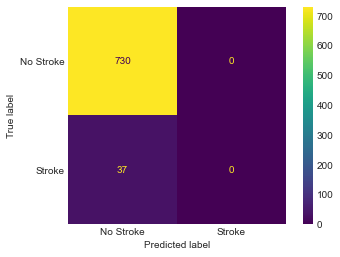

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_val, svm_pred, display_labels=['No Stroke','Stroke'])
plt.show()

We try to plot **Precision-Recall curve** below. Since the *true positives* and *false postives* are both 0 the plot is not too telling because precision and recall are both metrics defined in function of, amongst other, *true positives*.

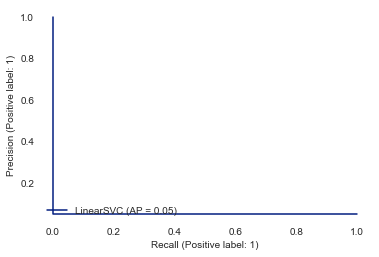

In [44]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_val, svm_pred, name="LinearSVC")
plt.show()

Furthermore, we plot the **ROC curve** that represents how good our predictive model is. Our model can play it safe or aggressively, however in our case we need to try to reduce the *false negatives (FN)* since we are in a medical context. It is desired to have too many *false positives (FP)* because a *false negative (FN)* diagnosis falsely reassures a doctor and patient that there is no risk for a stroke.

AUC:  0.7873750462791558


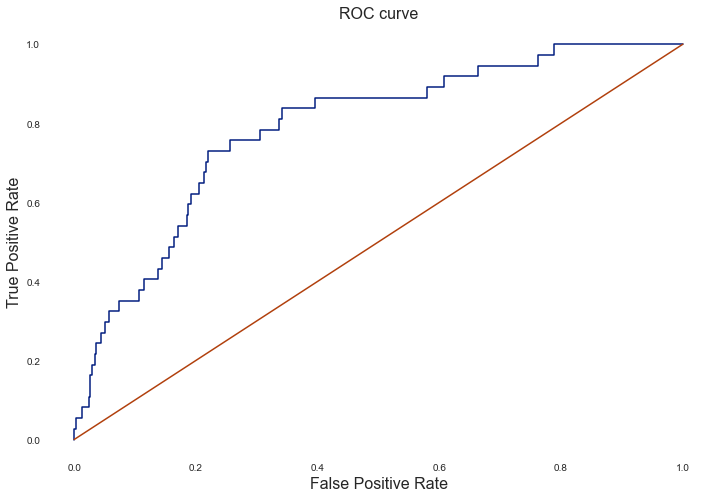

In [62]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, svm_pipeline.predict_proba(X_val)[:,1])

plt.figure(figsize=(12,8));
plt.plot(fpr, tpr);
plt.xlabel('False Positive Rate', fontsize=16);
plt.ylabel('True Positive Rate', fontsize=16);
plt.title('ROC curve', fontsize=16);
plt.plot([0, 1], [0, 1]);
#plt.axes().set_aspect('equal');
#sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False);

print('AUC: ', auc(fpr, tpr))

With an $AUC \approx 0.79$ we have an acceptable model.

In [46]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

#print(classification_report(y_val, svm_pred))
print(f'Validation Accuracy: {accuracy_score(y_val,svm_pred)}')
print(f'Training Accuracy: {accuracy_score(y_train,svm_train_pred)}')
print('############################################')
print(f'F1 Score: {f1_score(y_val,svm_pred)}')

Validation Accuracy: 0.9517601043024772
Training Accuracy: 0.9511876794570608
############################################
F1 Score: 0.0


---
### Model 2: Logistic Regression

The name of the model is Logistic Regression.

Logistic Regression is a statistical approach and a Machine Learning algorithm that is used for classification problems and is based on the concept of probability. It is used when the dependent variable (target) is categorical.

It is widely used when the classification problem at hand is binary; true or false, yes or no, etc.

Logistics regression uses the **sigmoid function** to return the probability of a label.

Sigmoid Function is a mathematical function used to map the predicted values to probabilities. The function has the ability to map any real value into another value within a range of 0 and 1.

$$f(x) = \frac{1}{1+e^{-x}}$$

These model also use a **Cost Function** to calculate the error, or the difference between our predicted value and the actual value.

In order to minimize our cost, we use **Gradient Descent** which estimates the parameters or weights of our model.

https://www.kdnuggets.com/2022/04/logistic-regression-classification.html

The parameter of the model is the **training data**

The model does not really have any critical hyperparameters to tune.

Sometimes, you can see useful differences in performance or convergence with :

* **solver:** Algorithm to use in the optimization problem. [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
* **penalty:** The norm of the penalty. [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]
* **C:** Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization. [100, 10, 1.0, 0.1, 0.01]
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


**Note:** Logistic regression makes no assumption about the distribution of features. So the biomodal distribution of ```avg_glucose_level``` is not an obstacle for applying this prediction model.

In [133]:
X_train_ = X_train[['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']]
X_val_ = X_val[['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']]
X_test_ = X_test[['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']]

In [134]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train_, y_train)
clf.predict(X_val_)
clf.score(X_val_, y_val)

0.9517601043024772

#### Evaluation

In [135]:
tn, fp, fn, tp = confusion_matrix(y_val, clf.predict(X_val_)).ravel()
print("False Negative (FN): ", fn)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("True Positive (TP): ", tp)

False Negative (FN):  37
True Negative (TN):  730
False Positive (FP):  0
True Positive (TP):  0


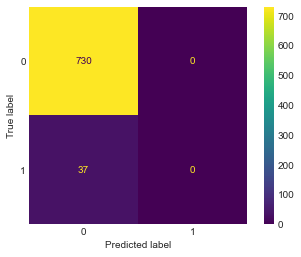

In [72]:
cm = confusion_matrix(y_val, clf.predict(X_val_))
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

y_score = clf.decision_function(df_input_variables_validation)

fpr, tpr, _ = roc_curve(df_target_variable_validation, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, f1_score, _ = precision_recall_fscore_support(df_target_variable_validation, clf.predict(df_input_variables_validation), average='binary')
print('Precision : ', prec)
print('Recall : ', recall)
print('F1 score : ', f1_score)

### Choosing a model (Test data)

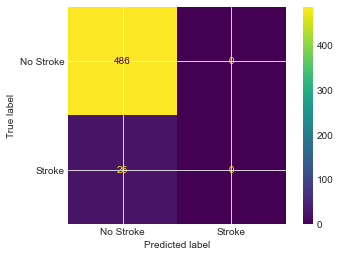

In [127]:
# Model 1
svm_pred = svm_pipeline.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, svm_pred, display_labels=['No Stroke','Stroke'])
plt.show()

## Conclusion

We still believe the class imbalance does not pose a problem. 
It may be probable that it is linked to another problem so we can attribute the bad performace of our prediction models to the scarsity of the data, as a consequence. Thus, for future work we should try to find a solution to this problem.

In addition, the dependence between features and target was not that strong. This could be another reason for the bad performance of our models.